<a href="https://colab.research.google.com/github/loenneberger/RL/blob/main/RL_taxi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
# Reinforcement Learning – Q-Learning auf Taxi-v3
# Funktion: Ein RL-Agent lernt, in einer kleinen Stadt Passagiere abzuholen und ans Ziel zu bringen

import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import imageio
from IPython.display import Image as IPImage
from IPython.display import display, HTML
from PIL import Image
from tqdm import tqdm


In [123]:
# Umgebung initialisieren
env = gym.make("Taxi-v3", render_mode=None)

In [124]:
# Q-Tabelle initialisieren (Zustände x Aktionen)
state_space_size = env.observation_space.n
action_space_size = env.action_space.n
q_table = np.zeros((state_space_size, action_space_size))

In [125]:
# Hyperparameter
alpha = 0.7              # Lernrate
gamma = 0.95             # Diskontierungsfaktor
epsilon = 1.0            # Anfangs-Epsilon (Exploration)
epsilon_min = 0.05       # Minimales Epsilon
epsilon_decay = 0.995    # Abnahmefaktor für Epsilon
episodes = 2000          # Trainings-Episoden
max_steps = 100          # Maximale Schritte pro Episode

In [126]:
# Für Visualisierung
reward_list = []

In [127]:
# Training
print("Training startet...")
for episode in tqdm(range(episodes)):
    state, _ = env.reset()
    done = False
    total_reward = 0

    for step in range(max_steps):
        # Aktionswahl: ε-greedy
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Exploration
        else:
            action = np.argmax(q_table[state])  # Exploitation

        new_state, reward, done, truncated, _ = env.step(action)

        # Q-Wert aktualisieren
        old_value = q_table[state, action]
        next_max = np.max(q_table[new_state])
        q_table[state, action] = old_value + alpha * (reward + gamma * next_max - old_value)

        state = new_state
        total_reward += reward

        if done or truncated:
            break

    # Epsilon reduzieren
    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    reward_list.append(total_reward)

print("Training abgeschlossen.")

Training startet...


100%|██████████| 2000/2000 [00:01<00:00, 1406.08it/s]

Training abgeschlossen.


In [128]:
# SARSA-Training
def train_sarsa(env, episodes=2000, alpha=0.7, gamma=0.95,
                epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.995,
                max_steps=100):

    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    reward_list = []

    for episode in tqdm(range(episodes), desc="SARSA Training"):
        state, _ = env.reset()
        total_reward = 0

        # Erste Aktion nach ε-greedy
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state])

        for step in range(max_steps):
            next_state, reward, done, truncated, _ = env.step(action)
            total_reward += reward

            # Nächste Aktion nach ε-greedy
            if random.uniform(0, 1) < epsilon:
                next_action = env.action_space.sample()
            else:
                next_action = np.argmax(q_table[next_state])

            # SARSA-Update
            old_value = q_table[state, action]
            next_value = q_table[next_state, next_action]
            q_table[state, action] = old_value + alpha * (reward + gamma * next_value - old_value)

            state = next_state
            action = next_action

            if done or truncated:
                break

        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        reward_list.append(total_reward)

    return q_table, reward_list


In [129]:
# Neue Umgebung für SARSA (damit keine Überschneidung mit Q-Learning)
env_sarsa = gym.make("Taxi-v3")
q_table_sarsa, rewards_sarsa = train_sarsa(env_sarsa)

SARSA Training: 100%|██████████| 2000/2000 [00:02<00:00, 987.29it/s] 


Frühe Episode (untrainiert): Reward = -50


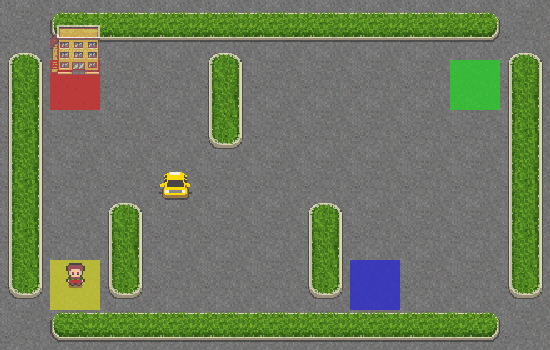

Späte Episode (trainiert): Reward = 8


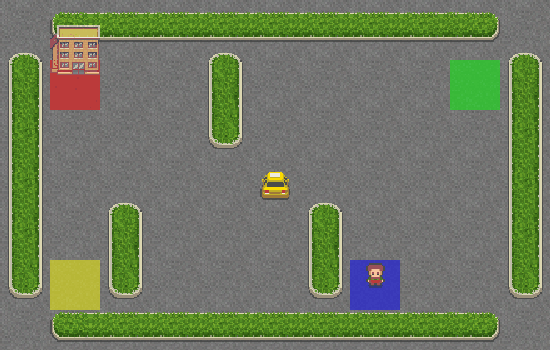

In [130]:
def run_episode_with_render(env, q_table, episode_name="episode", max_steps=50):
    state, _ = env.reset()
    frames = []
    total_reward = 0

    for step in range(max_steps):
        action = np.argmax(q_table[state])
        new_state, reward, done, truncated, _ = env.step(action)
        frame = env.render()
        frames.append(frame)
        total_reward += reward
        state = new_state
        if done or truncated:
            break

    gif_path = f"/tmp/{episode_name}.gif"
    imageio.mimsave(gif_path, frames, fps=1)
    return gif_path, total_reward

# Untrainierter Agent (leere Q-Tabelle)
q_table_random = np.zeros_like(q_table)
env_random = gym.make("Taxi-v3", render_mode="rgb_array")
gif_early, reward_early = run_episode_with_render(env_random, q_table_random, episode_name="early_random")

# Trainierter Agent
env_trained = gym.make("Taxi-v3", render_mode="rgb_array")
gif_late, reward_late = run_episode_with_render(env_trained, q_table, episode_name="late_trained")

# GIFs anzeigen und Reward ausgeben
print(f"Frühe Episode (untrainiert): Reward = {reward_early}")
display(IPImage(filename=gif_early))

print(f"Späte Episode (trainiert): Reward = {reward_late}")
display(IPImage(filename=gif_late))


SARSA – Frühe Episode (untrainiert): Reward = -50


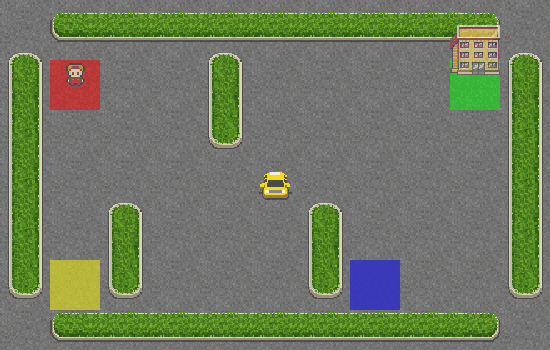

SARSA – Späte Episode (trainiert): Reward = 7


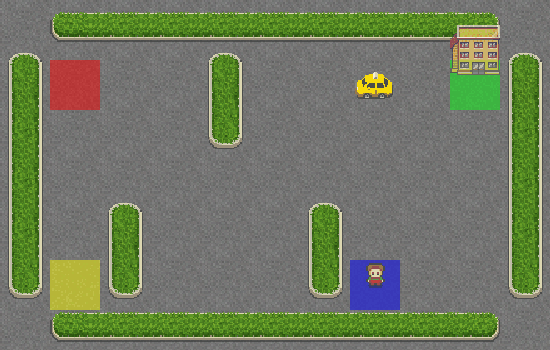

In [131]:
# Untrainierter SARSA-Agent (Q-Table leer)
env_sarsa_untrained = gym.make("Taxi-v3", render_mode="rgb_array")
q_table_empty = np.zeros_like(q_table_sarsa)
gif_sarsa_early, reward_sarsa_early = run_episode_with_render(env_sarsa_untrained, q_table_empty, "sarsa_early")


# Trainierter SARSA-Agent
env_sarsa_trained = gym.make("Taxi-v3", render_mode="rgb_array")
gif_sarsa_late, reward_sarsa_late = run_episode_with_render(env_sarsa_trained, q_table_sarsa, "sarsa_late")


print(f"SARSA – Frühe Episode (untrainiert): Reward = {reward_sarsa_early}")
display(IPImage(filename=gif_sarsa_early))

print(f"SARSA – Späte Episode (trainiert): Reward = {reward_sarsa_late}")
display(IPImage(filename=gif_sarsa_late))



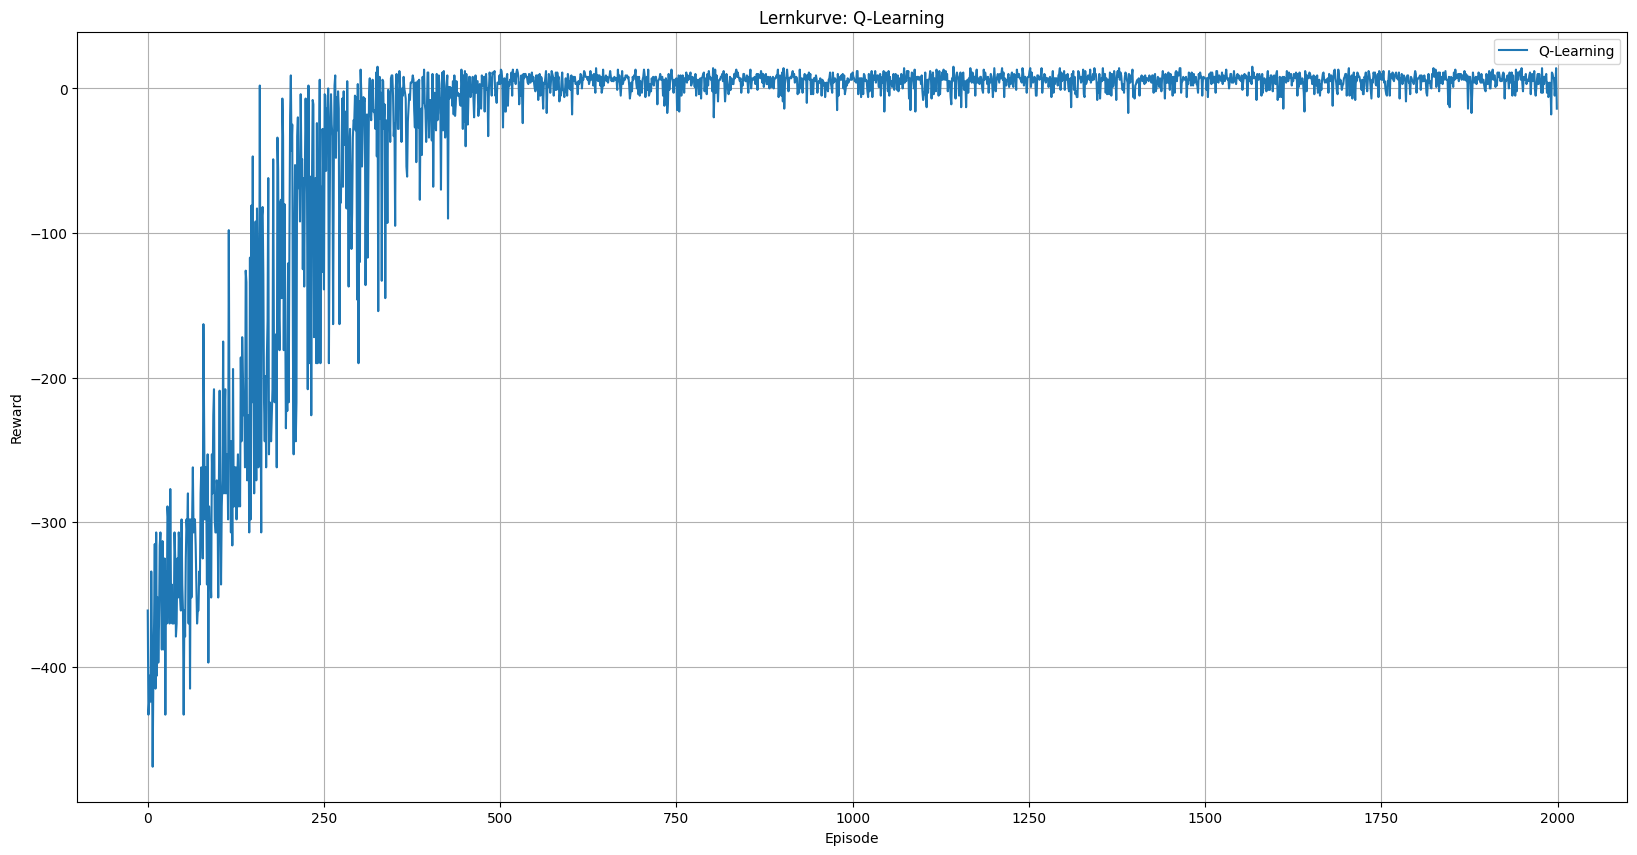

In [132]:
# Plot Q-Learning
plt.figure(figsize=(20, 10))
plt.plot(reward_list, label='Q-Learning')
plt.title("Lernkurve: Q-Learning")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)
plt.show()


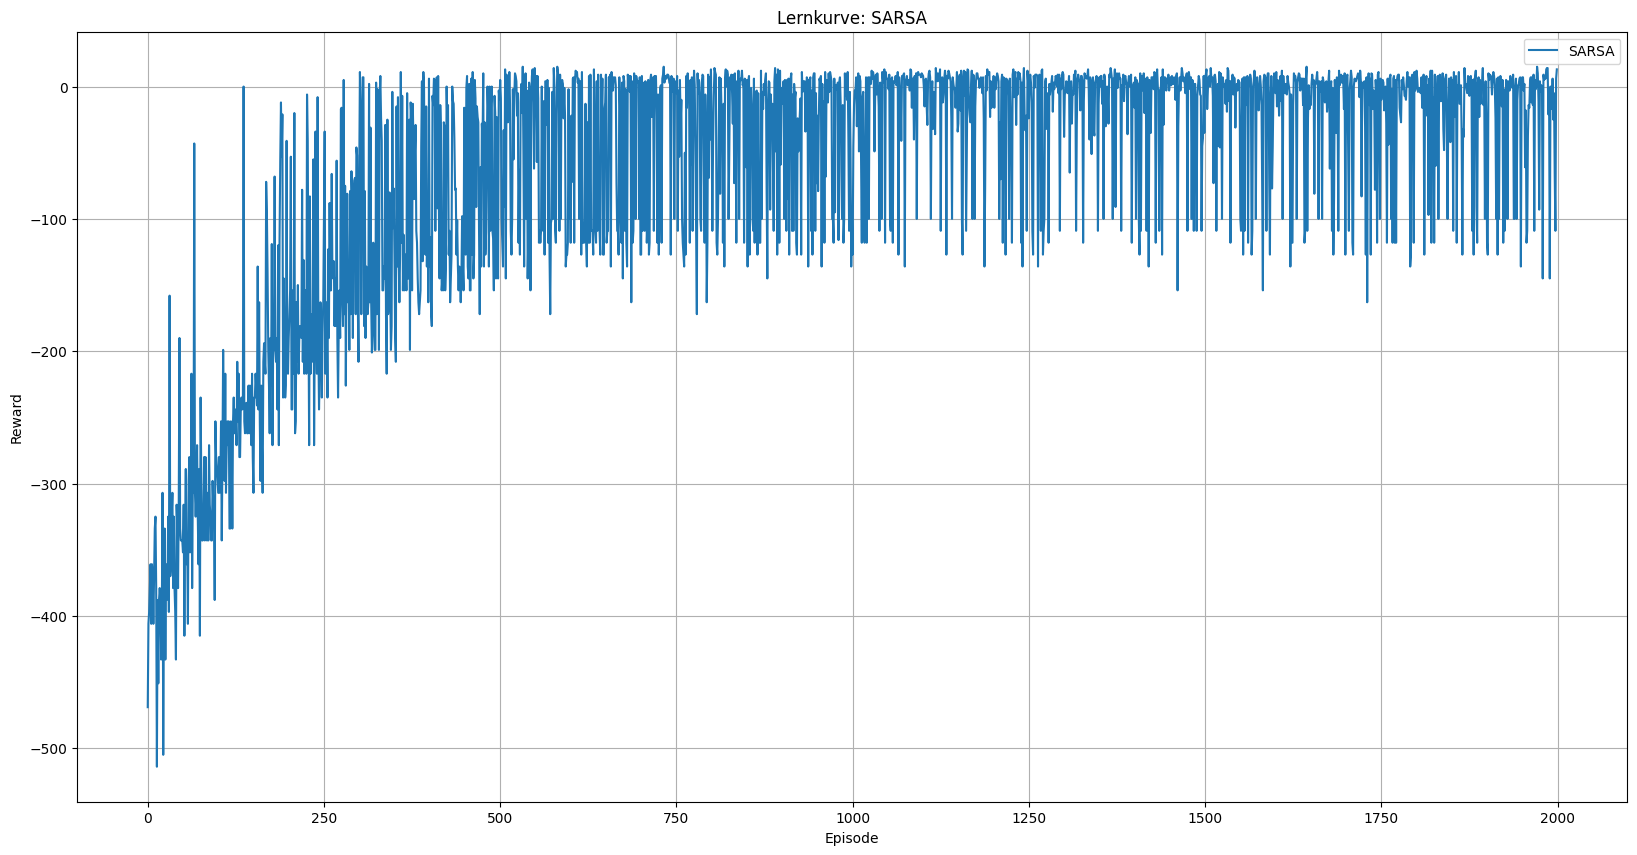

In [133]:
# Plot SARSA
plt.figure(figsize=(20, 10))
plt.plot(rewards_sarsa, label='SARSA')
plt.title("Lernkurve: SARSA")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)
plt.show()


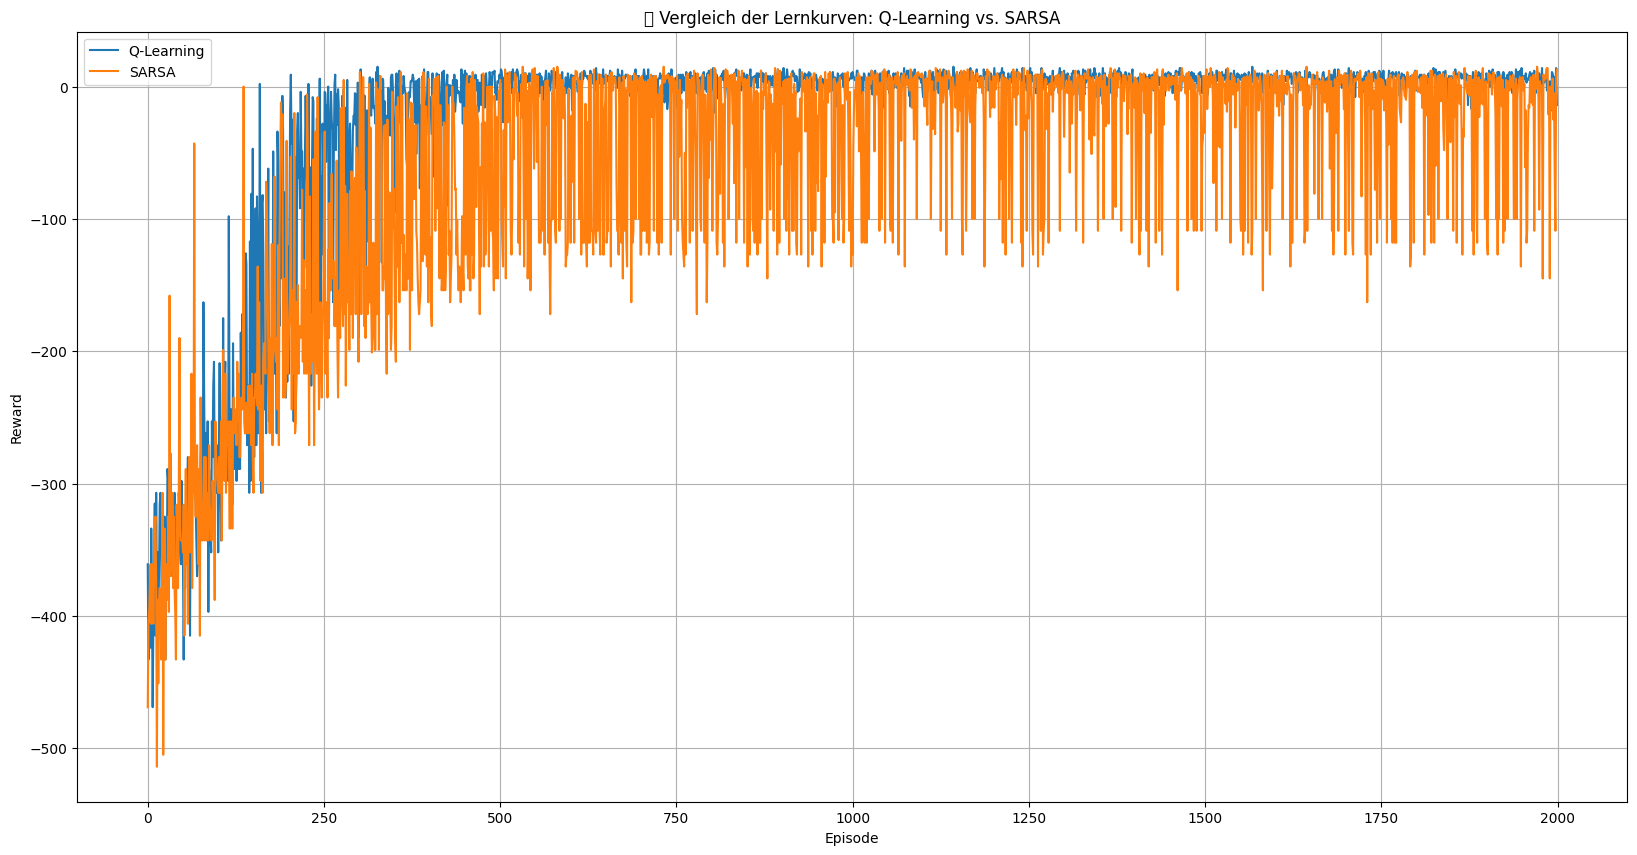

In [134]:
# Vergleich Q-Learning vs SARSA
plt.figure(figsize=(20, 10))
plt.plot(reward_list, label='Q-Learning')
plt.plot(rewards_sarsa, label='SARSA')
plt.title("📈 Vergleich der Lernkurven: Q-Learning vs. SARSA")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)
plt.show()


In [135]:
def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


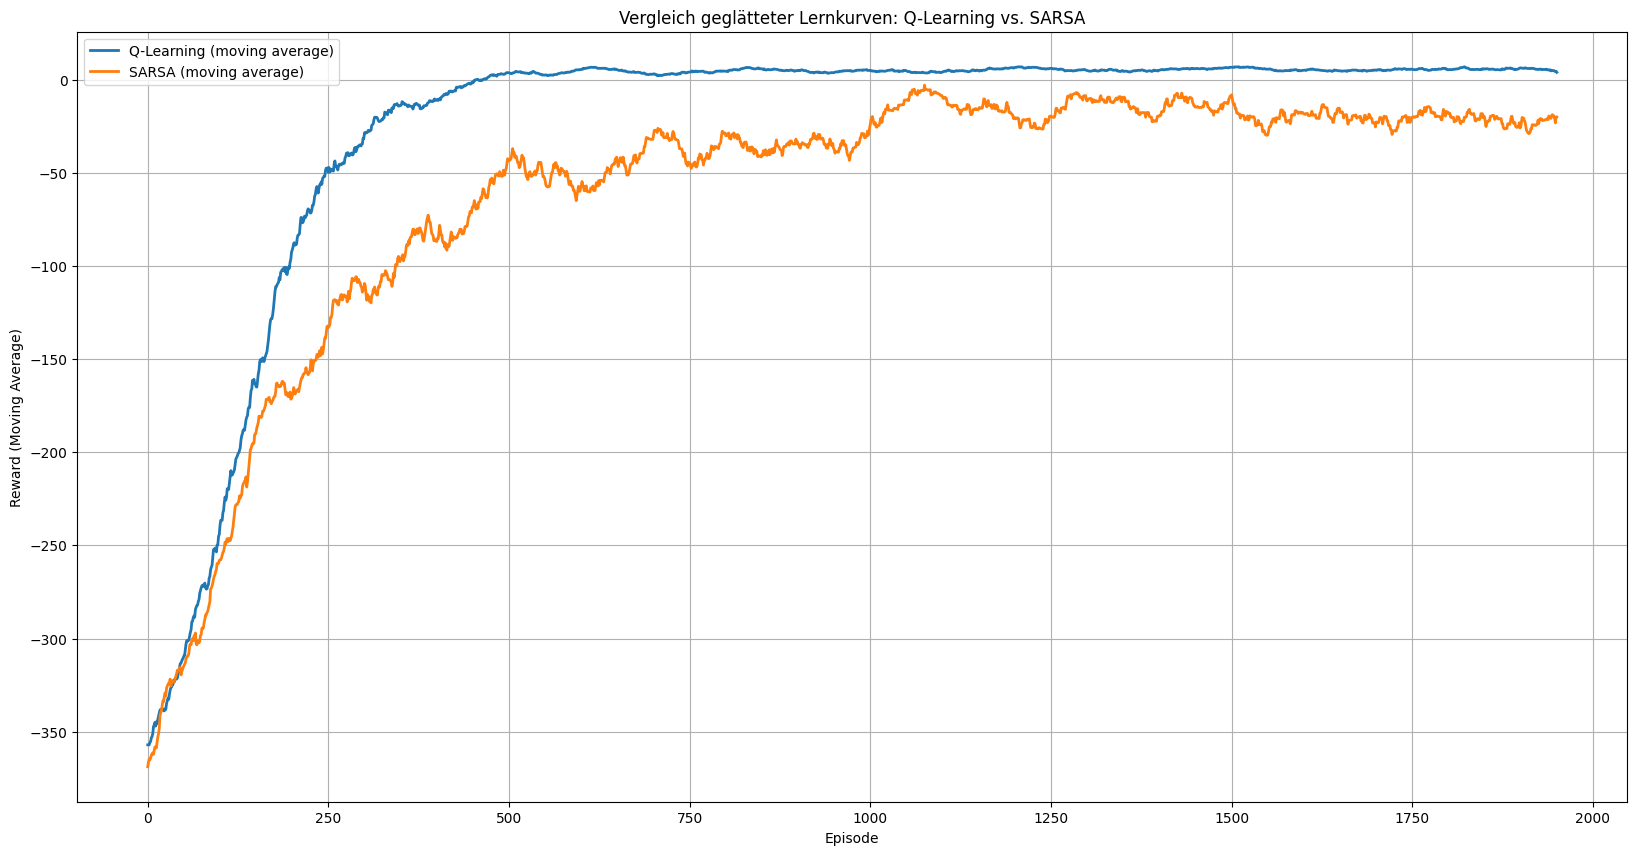

In [136]:
# Gleitende Mittelwerte berechnen
avg_q = moving_average(reward_list, window_size=50)
avg_sarsa = moving_average(rewards_sarsa, window_size=50)

# Geglätteter Vergleichsplot
plt.figure(figsize=(20, 10))
plt.plot(avg_q, label='Q-Learning (moving average)', linewidth=2)
plt.plot(avg_sarsa, label='SARSA (moving average)', linewidth=2)
plt.title("Vergleich geglätteter Lernkurven: Q-Learning vs. SARSA")
plt.xlabel("Episode")
plt.ylabel("Reward (Moving Average)")
plt.legend()
plt.grid(True)
plt.show()


Teile dieses Codes wurden mit Unterstützung von ChatGPT (OpenAI) generiert.
Die finalen Implementierungen wurden überprüft, getestet und ggf. angepasst.